In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['gentlemen i thank you all all arms have behaved heroically infantry',
 'the old feminine arts but as soon as the prince had gone her face',
 'berg smiled joyously the count by his guests went into the drawing',
 'the old count cast down his eyes on hearing his sons words and began',
 'if they had known that you wished it the entertainment would have been',
 'white smooth pillows evidently freshly changed pierre sawcovered to',
 'else runs upstairs and does up her hair and wags her tail and is unlike',
 'returned home just before dinner as soon as he entered he noticed and',
 'the report which had been circulated that the austrians had been beaten',
 'what to him was precious and sacred']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 5 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 5]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 32
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 1.1550,  1.2622, -1.0085,  ...,  1.5686, -0.9555, -0.6608],
        [ 1.0491,  0.5989,  0.1334,  ...,  0.4194, -1.0142,  0.2640],
        [ 1.4254,  0.0337, -0.7946,  ..., -1.7714, -0.8521, -2.1086],
        ...,
        [-0.0257, -0.0067, -2.0859,  ..., -0.8215,  1.1788, -0.0645],
        [ 0.1946, -0.5462, -0.7753,  ..., -0.5804, -0.1535, -0.2315],
        [ 1.2616, -0.1252,  0.5854,  ...,  0.5868,  0.3722,  1.0621]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.tanh(self.lin1(x))
        x = self.lin2(x)
        return x 
    


In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 1024).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 10:10:33.870000 138570842429248 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/2313360188.py line 8 
W1027 10:10:33.870000 138570842429248 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 10:10:33.870000 138570842429248 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 10:10:33.870000 138570842429248 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 10:10:33.870000 138570842429248 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 10:10:33.870000 138570842429248 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 10:10:33.870000 138570842429248 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 10:10:33.870000 138570842429248 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 meet move touches underneath avoid bory unjustly kind awkwardness encouraged surgeon bluntness impulsive pop trembled les flings ruffling jesus paced thereby cyrils aim smartly deah agitation silver counting corps waitresses obligatory frown examine droop bone awaiting jolting kempis relation judging sic undecided undergraduate minuteness screamed pacifying impossible rest restfully shot slaveslafe grenadiersfine halt base angrybut worldto wefused frowned glamour shooting radiance fatherwho cry breathlessly distinguishes creation footmen savagely begun happily mere bedouin create laggards voices overcoat waking todays river hushed puckered connections heap martyrlike children advise leaves dined overpowered shouts gallantry pressand snowed liffs private adoring entertaining dusk billeted pierrewho
 majestically interesting unhooked must blinked confirmed flies scandals pronouncing todayfrightful selfpreservation culminating ramrods whole outflank guessing gratefully sisters heaven y t

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 32])
_orig_mod.lin1.weight torch.Size([1024, 160])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([11189, 1024])
_orig_mod.lin2.bias torch.Size([11189])


In [15]:
len(stoi)

11189

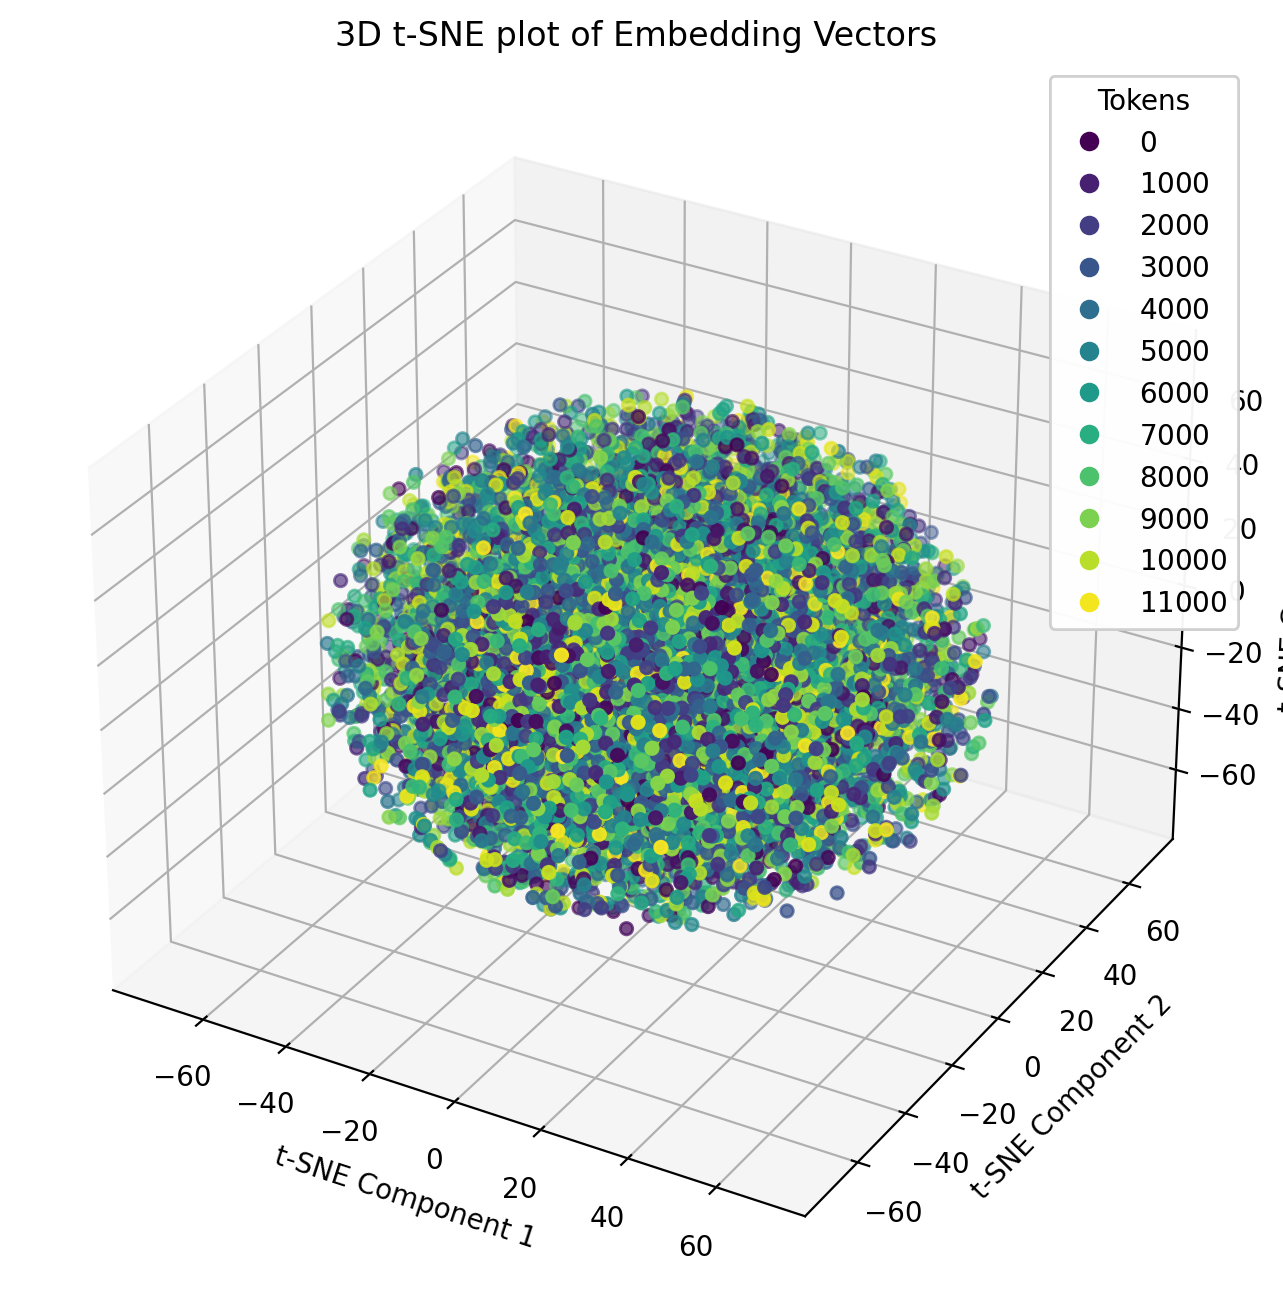

In [16]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [17]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 11.819450378417969
Epoch 10, Loss: 8.518081665039062
Epoch 20, Loss: 7.589625358581543
Epoch 30, Loss: 7.002264976501465
Epoch 40, Loss: 6.585108757019043
Epoch 50, Loss: 6.2571210861206055
Epoch 60, Loss: 5.974922180175781
Epoch 70, Loss: 5.723114490509033
Epoch 80, Loss: 5.494741439819336
Epoch 90, Loss: 5.287317276000977
Epoch 100, Loss: 5.099737167358398
Epoch 110, Loss: 4.9304914474487305
Epoch 120, Loss: 4.777776718139648
Epoch 130, Loss: 4.639359474182129
Epoch 140, Loss: 4.5129075050354
Epoch 150, Loss: 4.396306037902832
Epoch 160, Loss: 4.287854194641113
Epoch 170, Loss: 4.186182975769043
Epoch 180, Loss: 4.090394496917725
Epoch 190, Loss: 3.9996509552001953
Epoch 200, Loss: 3.91335391998291
Epoch 210, Loss: 3.831148147583008
Epoch 220, Loss: 3.752563953399658
Epoch 230, Loss: 3.6773552894592285
Epoch 240, Loss: 3.6053574085235596
Epoch 250, Loss: 3.5364456176757812
Epoch 260, Loss: 3.4705235958099365
Epoch 270, Loss: 3.407442092895508
Epoch 280, Loss: 3.3470482

In [18]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 what ill do we andrew said to you to find of in countess
 
 translation of removing that of all
 eldest princess and not once at the room of preeminence rubles saber he but i know who
 societys not cuisse for a long time said the intercourse and was in poland he spoke to himself
 to rostovs was a saying what very we he did not see
 approaching departure by a russian army helplessness removing
 were being himself only intimidated unpleasant with
 aim that in this is considerably on our
 denisov paused nicholas on him


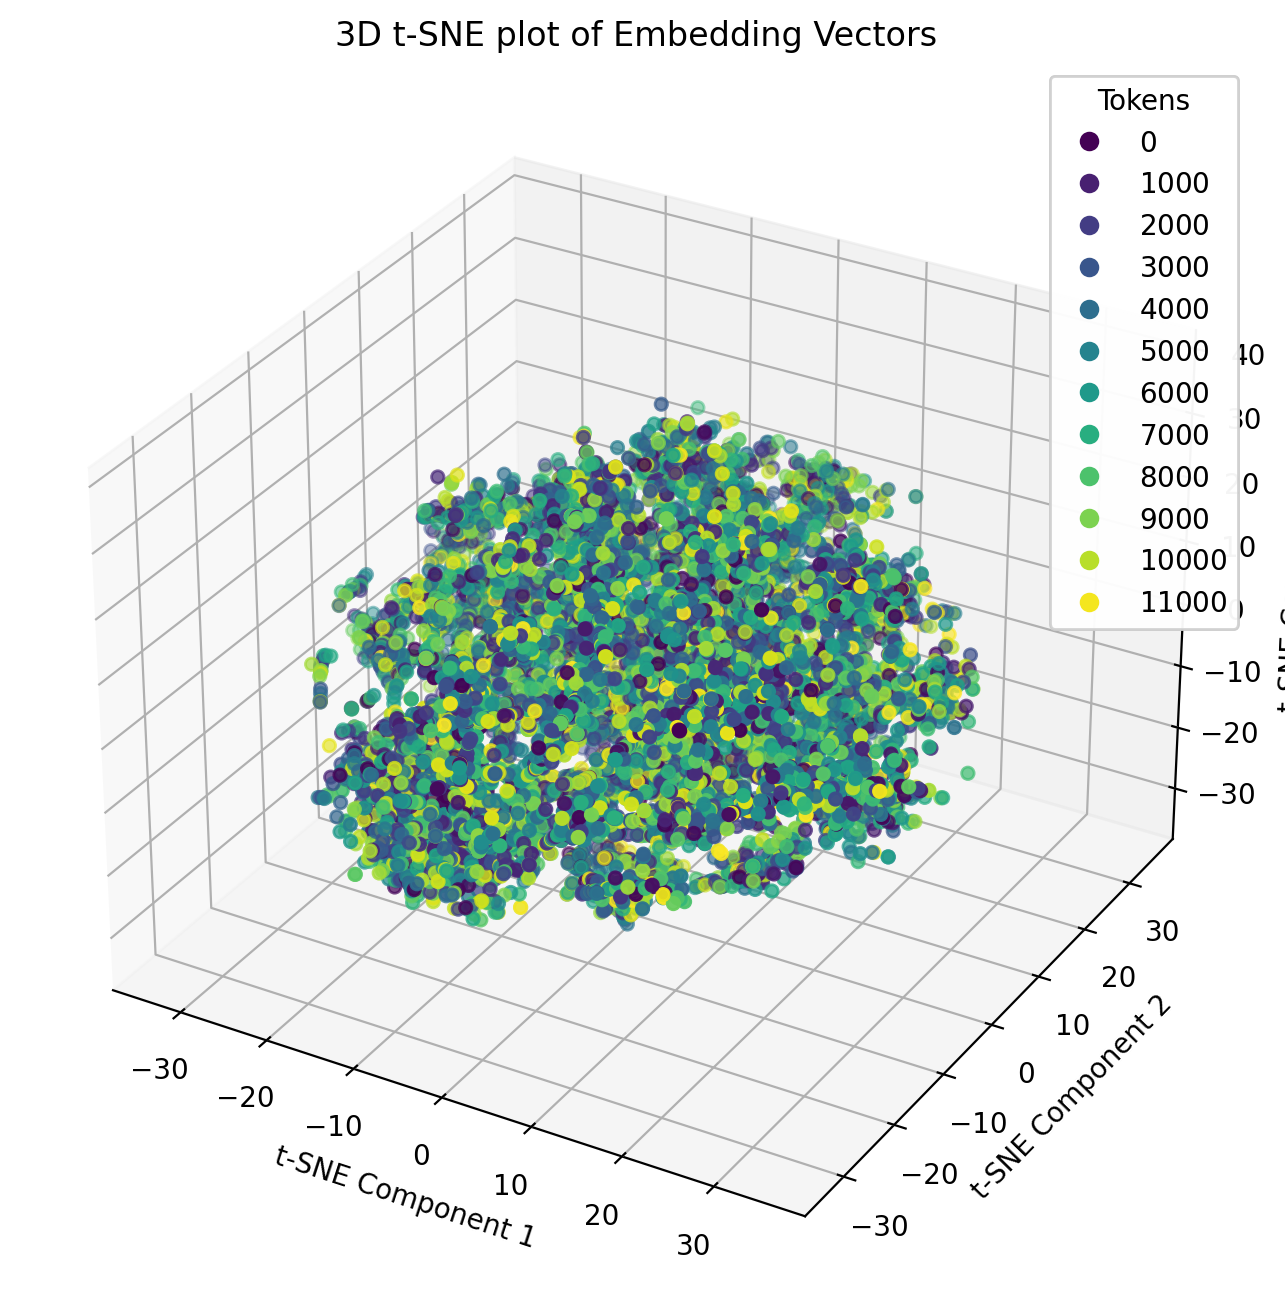

In [19]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [20]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_5_32_1024_t.pth")

In [21]:
model = model.to(device)